# Modeling & Classification.

aca anotar lo q se quiere probar

recordar utilizar metricas de comparación

https://huggingface.co/julien-c/distilbert-feature-extraction

CountVectorizer, TFIDF, LSA, LDA, SBERT, spaCy

ideas:
    (1,2) ngrams of Qpos + Apos   
    (1,2) ngrams of Qlemmas  
    (1,2) ngrams of Alemmas   
    (1,2) ngrams of AQlemmas   

 usar varios clusters, uno de 3grams, uno de nouns, uno de embeddings

 con esto buscar un clasificador multilabel (o simplemente agregarlos como features del modelo que le fedee al clasificador)

ya tengo el codigo para agregar features

In [49]:
from TCA import *

import pandas as pd
import numpy as np

df = pd.read_csv("db/features.csv", index_col=0)
df = df.set_index("id")

test_df = pd.read_csv("db/test_db.csv", index_col=0)
true_df = test_df[test_df["2"]]
false_df = test_df[test_df["2"] == False]



## Vectorial Representations

### CountVectorizers

### 2-3 ngrams in Question

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

def cv_ngrams(docs, range=(2,3), min_df=20):
    
    #2 y 3 ngrams, minimo 20 (no se como elegir le numero correcto)
    cv = CountVectorizer(min_df=min_df, ngram_range=range)

    
    #Create, Normalize and Reduce 
    vspace = cv.fit_transform(docs)
    vspace = normalize(vspace, axis=1, norm="max")
    vspace = VarianceThreshold(threshold=1e-3).fit_transform(vspace)

    return vspace

vs = cv_ngrams(df["Q"])
vs


<98182x704 sparse matrix of type '<class 'numpy.float64'>'
	with 338111 stored elements in Compressed Sparse Row format>

## Clustering


### Obteniendo el número de clusters 
https://towardsdatascience.com/10-tips-for-choosing-the-optimal-number-of-clusters-277e93d72d92
https://towardsdatascience.com/k-means-clustering-and-the-gap-statistics-4c5d414acd29
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html


### Implementando el metodo de elbow

/home/mauro/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/mauro/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/mauro/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/mauro/.local/lib

12

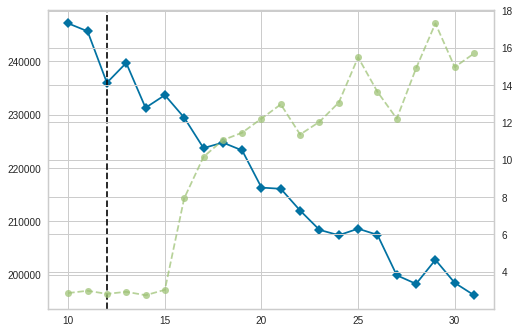

In [47]:

#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
from yellowbrick.cluster import KElbowVisualizer

#https://scikit-learn.org/stable/modules/clustering.html
model = KMeans()
visualizer = KElbowVisualizer(model, k=(10,32))

visualizer.fit(vs)

n_clusters =  visualizer.elbow_value_

#visualizer.show()    
n_clusters

In [46]:
from sklearn.cluster import KMeans

kmc = KMeans(n_clusters=n_clusters, random_state=0)
kmc.fit(X=vs)
df["label1"] = kmc.labels_

#vemos los primeros clusters, al ser con ngrams  la forma en la que comienza la pregunta tiene mucho peso
def print_kmc_clus(n=5):
    import random
    q_clus = [[] for i in range(n_clusters)]

    for sentence_id, cluster_id in enumerate(kmc.labels_):
        q_clus[cluster_id].append(df.iloc[sentence_id].Q)

    for i, cluster in enumerate(q_clus):
        print("Cluster ", i+1)
        for tw in random.sample(cluster, n):
            print(tw)



<bound method BaseEstimator._check_feature_names of KMeans(n_clusters=11, random_state=0)>

### Meassuring "presition"

inertia, silhuete, own_metric


In [35]:

#Compara la cantidad de aciertos con los df de test
def check_results():

    n = len(true_df)
    m = len(false_df)
    same_c = 0
    for i in range(n):
        if int(df.loc[true_df.iloc[i][0]].label1) ==  int(df.loc[true_df.iloc[i][1]].label1):
            same_c += 1
    
    diff_c = 0
    for i in range(m):
        if int(df.loc[false_df.iloc[i][0]].label1) !=  int(df.loc[false_df.iloc[i][1]].label1):
            diff_c += 1
        
    return same_c/n, diff_c/m
        
check_results()
    

(0.6633535353535354, 0.6762467624676247)

In [58]:
#continuo viendo que funciona

#embeddings preentrenados
# import gensim.downloader

# #word2vec-google-news-300
# w2v = gensim.downloader.load('glove-twitter-25')
# w2v["mauro"]

df

,Q,Qscore,Qless,Qlemmas,Qpos,Qtoks,ANS,ANSscore,Aless,Alemmas,Apos,Atoks,label2
id,,,,,,,,,,,,,
100b8y,"First time drinking, what do I do?",7,"First time drinking, I ?","First time drinking , I ?","[('First', 'JJ'), ('time', 'NN'), ('drinking',...","['First', 'time', 'drinking', ',', 'I', '?']","try not mix drinks.., if you start with spirit...",12.0,"try mix drinks.., start spirits finish spirits..","try mix drink .. , start spirit finish spirit ..","[('try', 'VB'), ('mix', 'JJ'), ('drinks', 'NNS...","['try', 'mix', 'drinks', '..', ',', 'start', '...",0
100nsq,Should I or should I not upgrade to Windows 8?,5,Should I I upgrade Windows 8?,Should I I upgrade Windows 8 ?,"[('Should', 'MD'), ('I', 'PRP'), ('I', 'PRP'),...","['Should', 'I', 'I', 'upgrade', 'Windows', '8'...",how about dualboot?,6.0,dualboot?,dualboot ?,"[('dualboot', 'NN'), ('?', '.')]","['dualboot', '?']",0
102xlc,What makes you smile?,123,What makes smile?,What make smile ?,"[('What', 'WP'), ('makes', 'VBZ'), ('smile', '...","['What', 'makes', 'smile', '?']",zygomatic major and orbicularis oculi,172.0,zygomatic major orbicularis oculi,zygomatic major orbicularis oculus,"[('zygomatic', 'JJ'), ('major', 'JJ'), ('orbic...","['zygomatic', 'major', 'orbicularis', 'oculi']",1
103c5q,What was your ego boost today?,5,What ego boost today?,What ego boost today ?,"[('What', 'WP'), ('ego', 'VBZ'), ('boost', 'NN...","['What', 'ego', 'boost', 'today', '?']",Yesterday I was told that I look like Emma Sto...,5.0,Yesterday I told I look like Emma Stone. I fee...,Yesterday I told I look like Emma Stone . I fe...,"[('Yesterday', 'NN'), ('I', 'PRP'), ('told', '...","['Yesterday', 'I', 'told', 'I', 'look', 'like'...",2
103hv3,What is the worst way to die you can think of?,199,What worst way die think ?,What worst way die think ?,"[('What', 'WP'), ('worst', 'JJS'), ('way', 'NN...","['What', 'worst', 'way', 'die', 'think', '?']",there was a video from a few years ago of a ch...,201.0,video years ago chechnian guy getting throat c...,video year ago chechnian guy getting throat cu...,"[('video', 'CD'), ('years', 'NNS'), ('ago', 'R...","['video', 'years', 'ago', 'chechnian', 'guy', ...",-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ozgvlf,How did you get rid of depression?,1,How get rid depression?,How get rid depression ?,"[('How', 'WRB'), ('get', 'VB'), ('rid', 'JJ'),...","['How', 'get', 'rid', 'depression', '?']","I can't, I can only reduce my sadness by worki...",1.0,"I ', I reduce sadness working something I like","I ' , I reduce sadness working something I like","[('I', 'PRP'), (""'"", ""''""), (',', ','), ('I', ...","['I', ""'"", ',', 'I', 'reduce', 'sadness', 'wor...",-1
ozgw90,What is your kink?,1,What kink?,What kink ?,"[('What', 'WP'), ('kink', 'VB'), ('?', '.')]","['What', 'kink', '?']",Snuff films.,1.0,Snuff films.,Snuff film .,"[('Snuff', 'NNP'), ('films', 'NNS'), ('.', '.')]","['Snuff', 'films', '.']",15
ozgwry,What time do you wake up and go to sleep?,1,What time wake go sleep?,What time wake go sleep ?,"[('What', 'WP'), ('time', 'NN'), ('wake', 'NN'...","['What', 'time', 'wake', 'go', 'sleep', '?']","Wake up in 5am, sleep in 8pm",1.0,"Wake 5am, sleep 8pm","Wake 5am , sleep 8pm","[('Wake', 'VB'), ('5am', 'CD'), (',', ','), ('...","['Wake', '5am', ',', 'sleep', '8pm']",2196


## Classifying 
